In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

In [2]:
M,N = 1000,1000000
A = np.ones((M,N))
B = np.ones((N,M))
C = np.dot(A,B)

In [3]:
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import LsNMF
import torch
import time

```python setup.py build_ext --inplace```

# Load & Format Data

In [4]:
arrays={}
g = h5py.File('Vc_Uc.mat')
for k, v in g.items():
    print(k)
    arrays[k] = np.array(v)

Uc
Vc
brainmask_aligned
newtrialidxs


In [5]:
new_x, new_y = 580, 540
dorsalMapScaled = sio.loadmat('dorsalMaps.mat')['dorsalMapScaled']
dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] = dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] * -1
dorsalMapScaled = dorsalMapScaled[:new_y, :new_x]

In [6]:
V=arrays['Vc'].T

In [7]:
U=arrays['Uc'].transpose((2,1,0))[:new_y, :new_x, :]
brainmask=~np.isnan(arrays['brainmask_aligned'].T[:new_y, :new_x])
trialidxs=arrays['newtrialidxs'].T
del arrays

In [8]:
q, r = np.linalg.qr(V.T)

# adaptive_localized_factorize(...)

In [9]:
video_mats = (np.copy(U[brainmask]), r.T)#V)
del U
valid_mask = brainmask
region_map = dorsalMapScaled
rank_range = (2, 14, 1)
device='cpu'

In [10]:
region_mats = LsNMF.extract_region_metadata(valid_mask,
                                            region_map,
                                            min_size=rank_range[1])

In [11]:
A = np.zeros(valid_mask.shape, dtype=np.float32)
A[valid_mask] = region_mats[1][1]

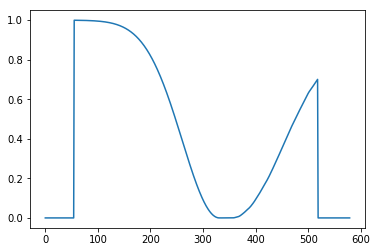

In [12]:
sigma=.0001
plt.plot(np.arange(len(A[200])), 1 - np.exp(-1*np.power(A[300],2) * sigma))
plt.show()

In [13]:
region_mats[1][:] = 1 - np.exp(-1*np.power(region_mats[1],2) * sigma)

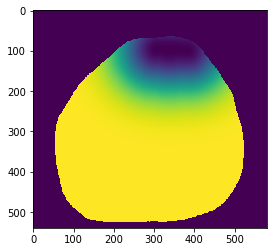

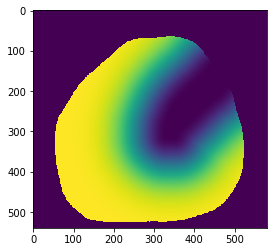

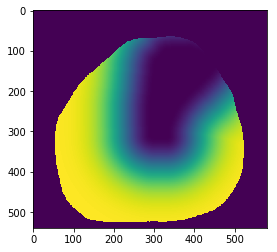

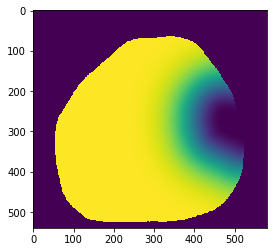

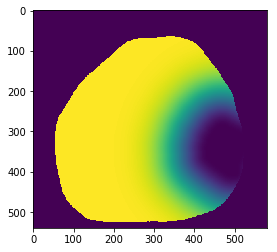

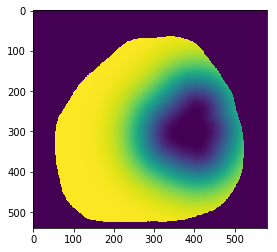

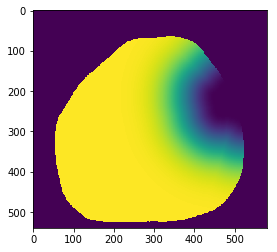

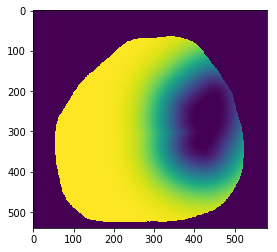

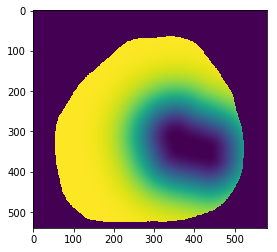

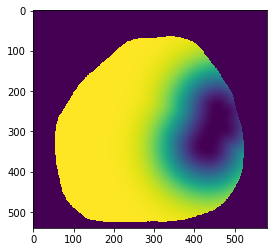

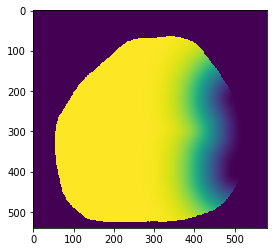

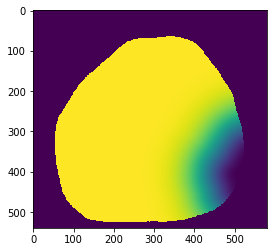

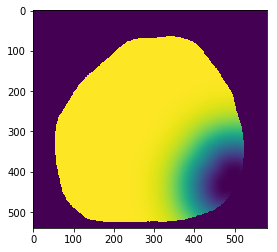

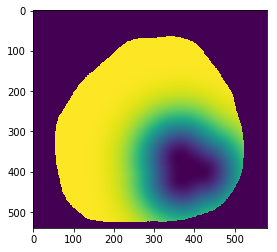

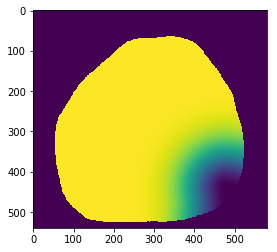

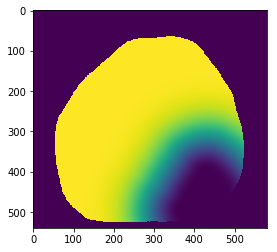

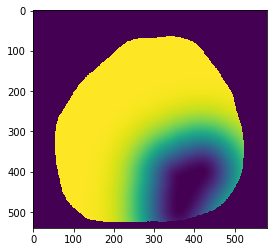

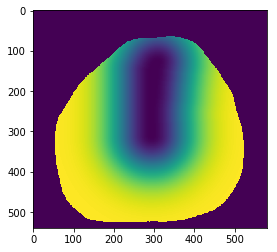

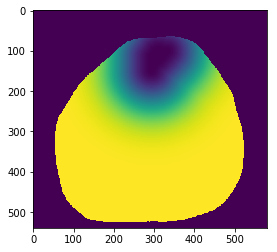

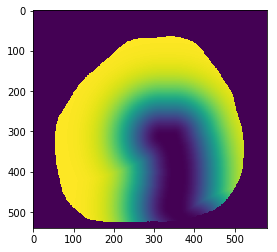

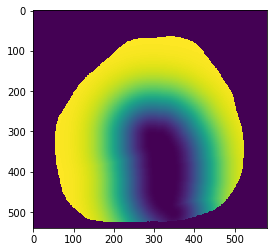

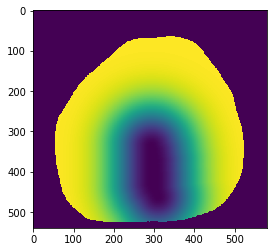

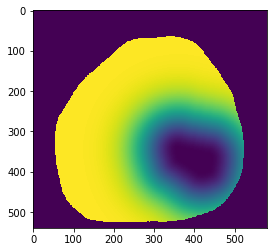

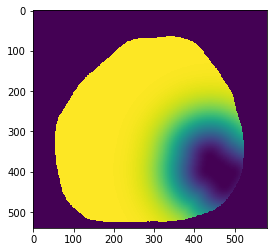

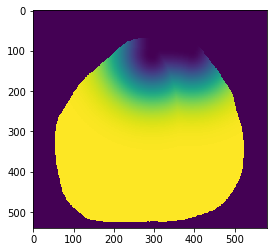

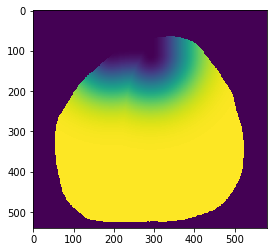

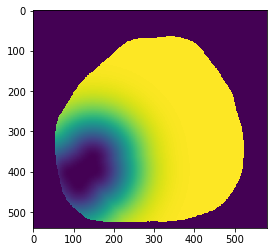

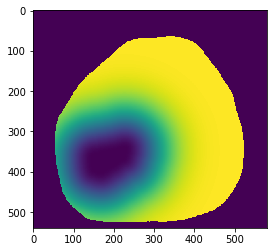

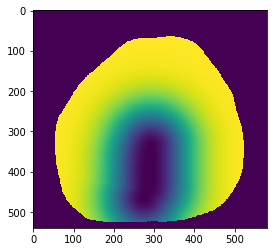

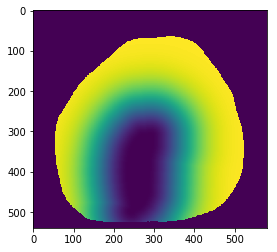

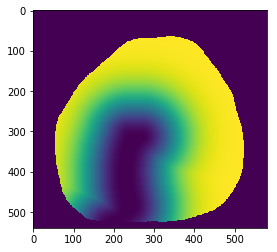

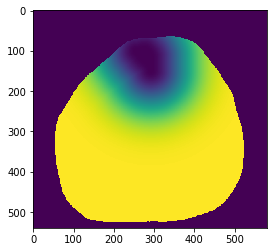

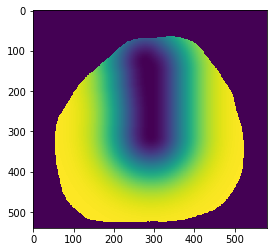

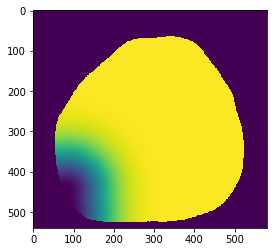

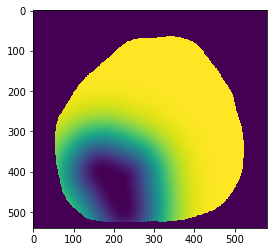

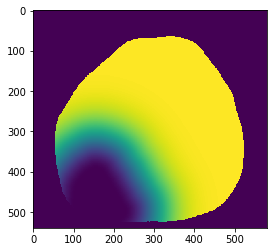

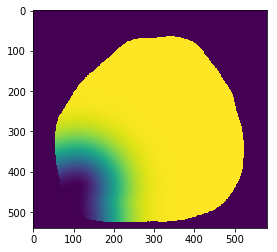

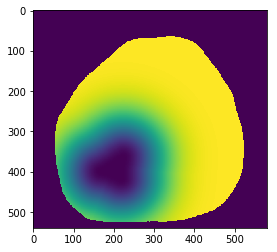

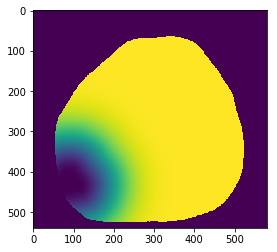

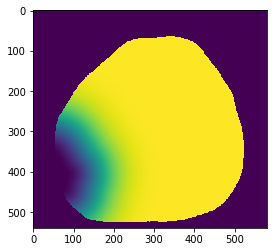

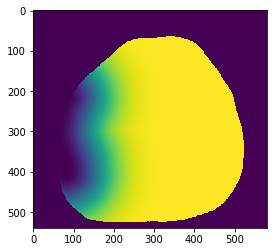

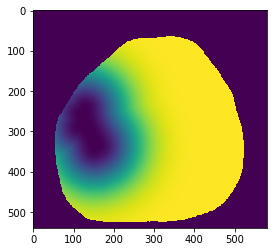

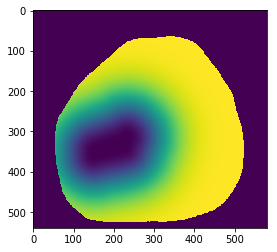

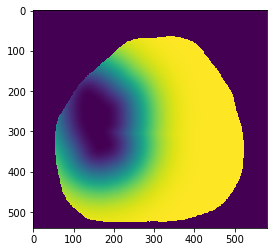

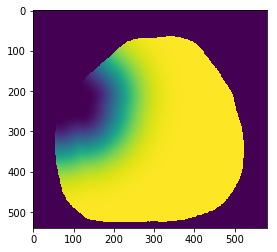

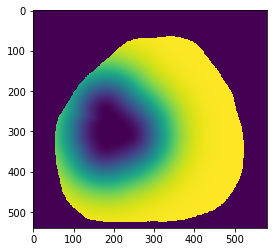

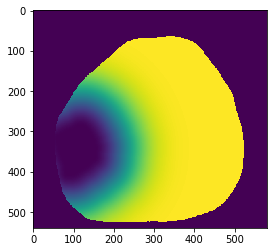

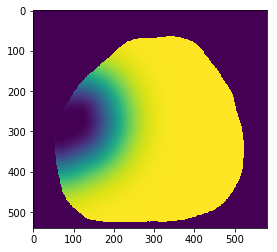

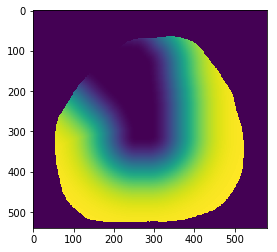

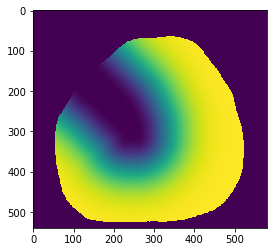

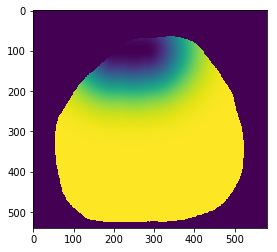

In [14]:
A = np.zeros(valid_mask.shape, dtype=np.float32)
for dist in region_mats[1]:
        A[valid_mask] = dist
        plt.imshow(A)
        plt.show()

In [15]:
region_metadata = LsNMF.RegionMetadata(region_mats[0].shape[0],
                                       region_mats[0].shape[1:],
                                       device=device)

In [16]:
region_metadata.set(torch.from_numpy(region_mats[0].astype(np.uint8)),
                    torch.from_numpy(region_mats[1]),
                    torch.from_numpy(region_mats[2].astype(np.int64)))

In [17]:
torch.cuda.synchronize()
print('v SVD Initialization')
t0 = time.time()
region_videos = LsNMF.factor_region_videos(video_mats,
                                           region_mats[0],
                                           rank_range[1],
                                           device=device)
torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))

v SVD Initialization
'-total : 3.210163


In [18]:
low_rank_video = LsNMF.LowRankVideo(
    (int(np.sum(valid_mask)),) + video_mats[1].shape,
    device=device
)

In [19]:
low_rank_video.set(torch.from_numpy(video_mats[0].T),
                   torch.from_numpy(video_mats[1]))

In [ ]:
torch.cuda.synchronize()
print('v Rank Line Search')
t0 = time.time()
debug = LsNMF.rank_linesearch(low_rank_video,
                              region_metadata,
                              region_videos,
                              maxiter_rank=50,
                              maxiter_lambda=200,
                              maxiter_hals=15,
                              lambda_step=1.35,
                              lambda_init=1e-3,
                              loc_thresh=50,
                              r2_thresh=.98,
                              rank_range=rank_range,
                              verbose=[True, False, False],
                              sample_prop=(1,1),
                              device=device)
torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))

v Rank Line Search
|--v Rank Line Search Iteration 0
|  |--v Initialization
|  |  '-total : 0.109805 seconds
|  |--v Lambda Line Search


Single-Threaded CPU Iterations
1. ```1870.31 seconds```
2. ```2088.71 seconds```

```estimated total : 13804.0165 seconds / 230.0669 minutes / 3.83 hours```

Multi-Threaded (8x) CPU Iterations
1. ```1870.31 seconds```
2. ```2088.71 seconds```

GPU Iterations
1. ```18.4642 seconds```
2. ```20.3065 seconds```

```total : 138.040165 seconds / 2.300669 minutes / .0383 hours```

In [20]:
len(debug)

122

In [31]:
region_ranks = [0]
region_idx = []
for rdx in torch.unique(debug.regions.data):
    region_ranks.append(torch.sum(rdx == debug.regions.data).item())
    region_idx.append(rdx.item())

In [32]:
print((np.min(region_ranks),
       np.mean(region_ranks),
       np.max(region_ranks)))

(0, 2.326923076923077, 9)


In [33]:
print((np.sum(np.array(region_ranks) == np.max(region_ranks)), len(region_metadata)))

(1, 51)


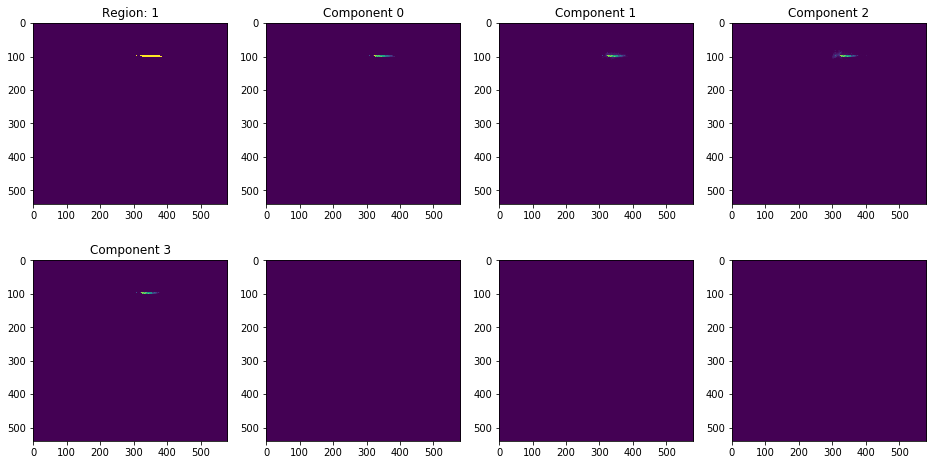

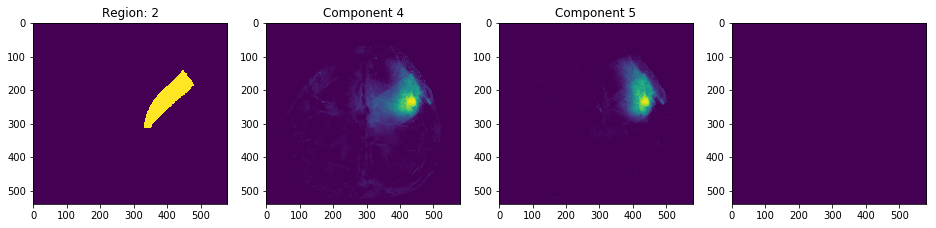

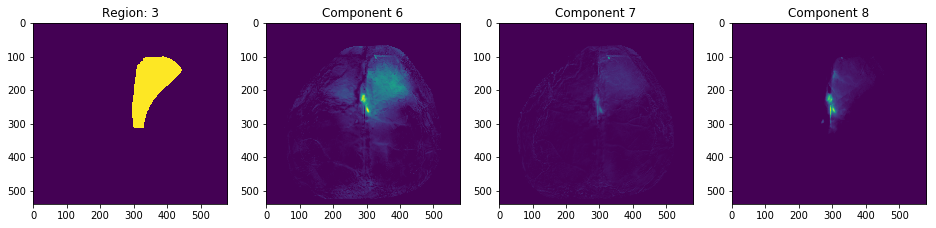

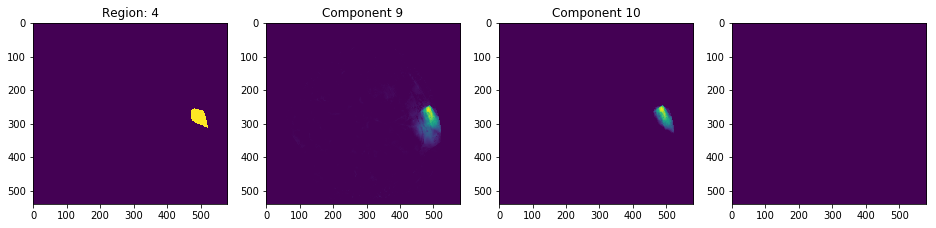

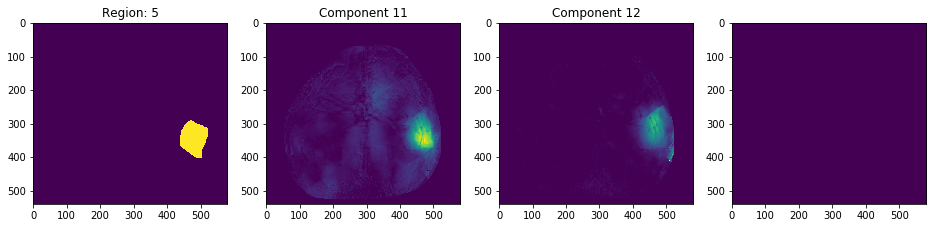

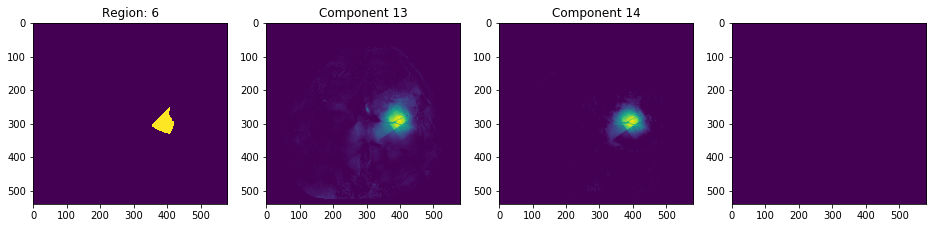

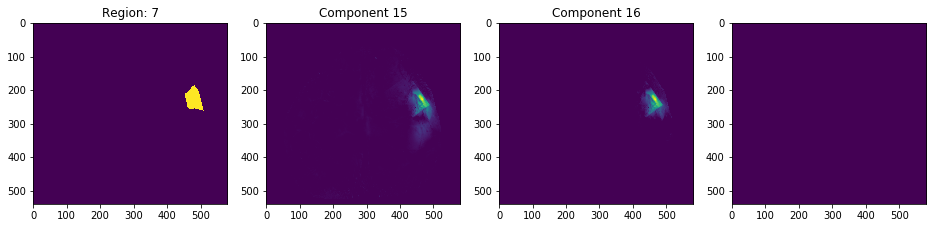

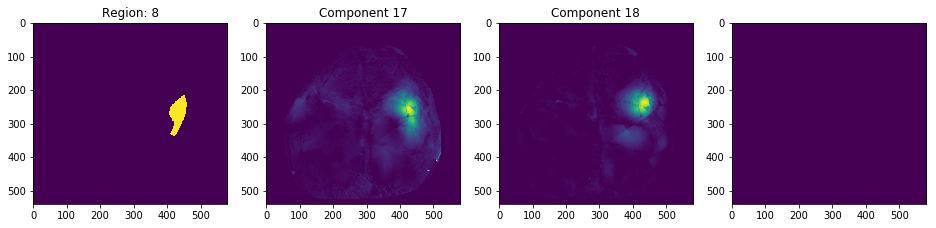

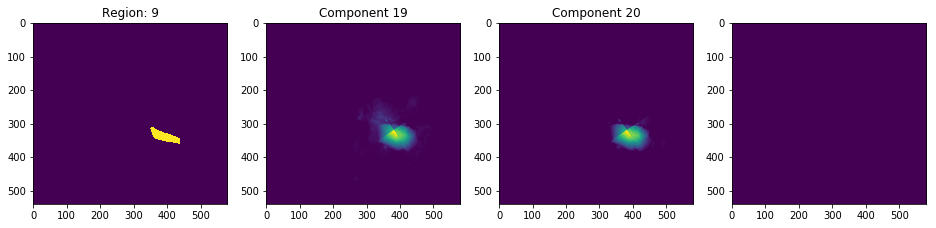

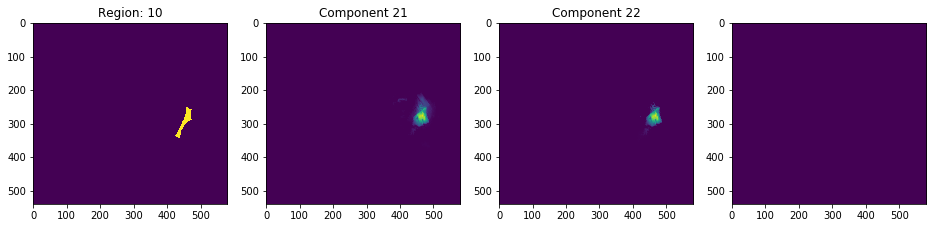

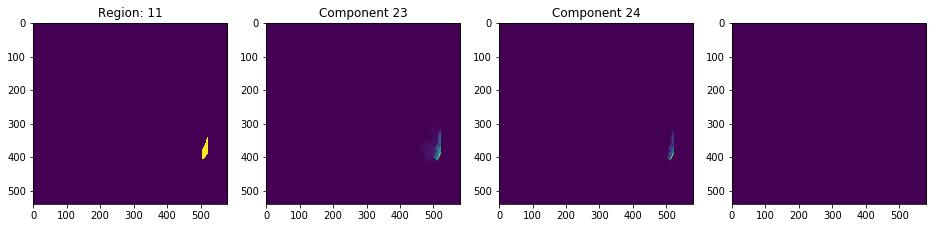

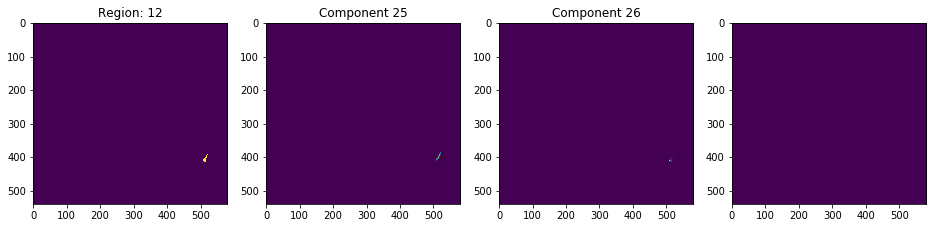

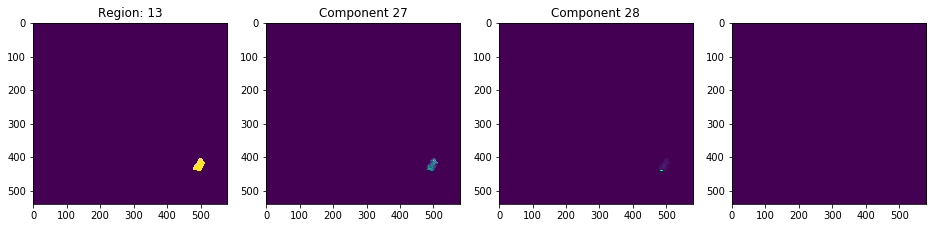

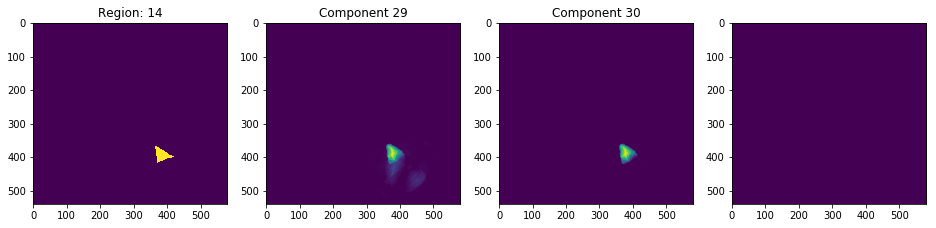

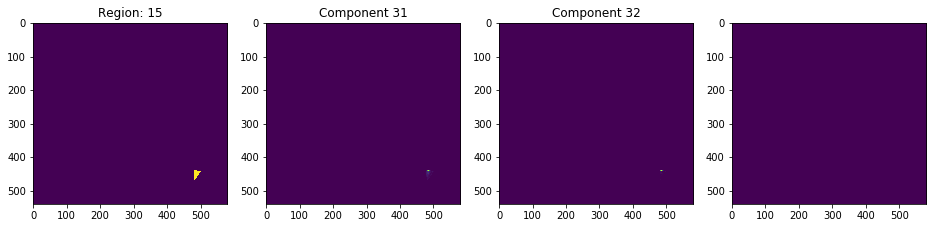

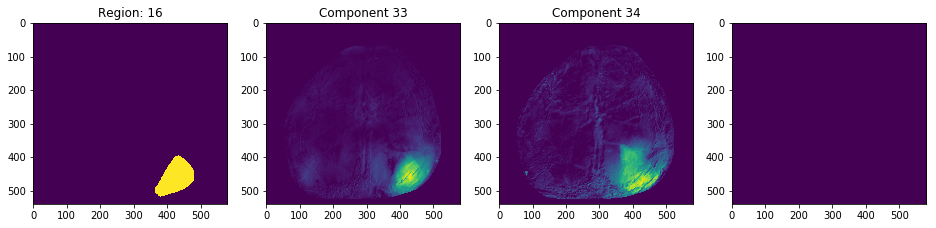

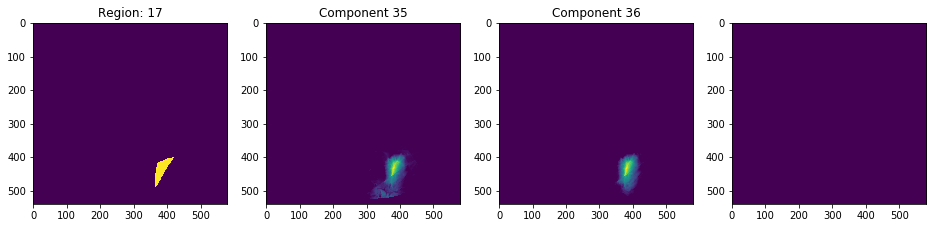

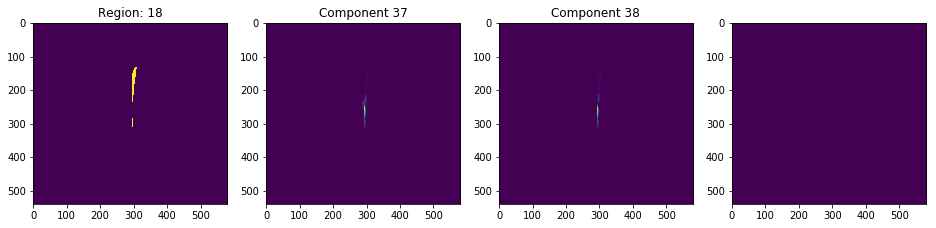

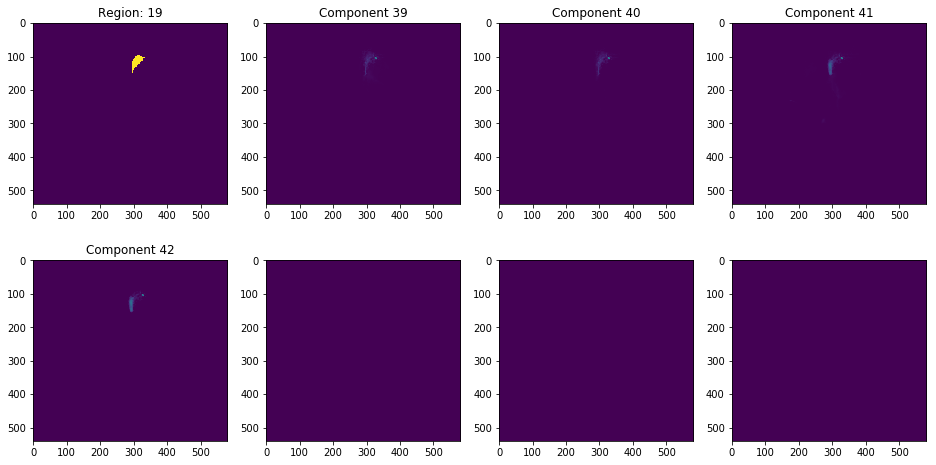

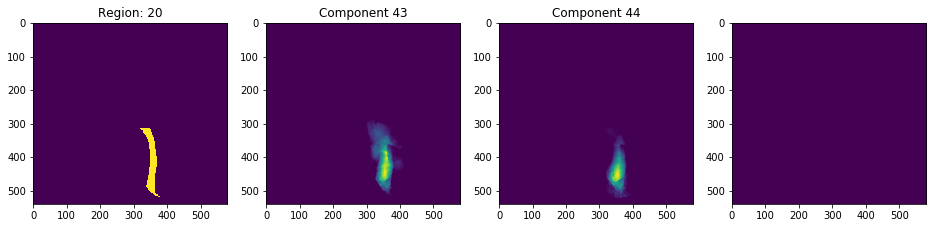

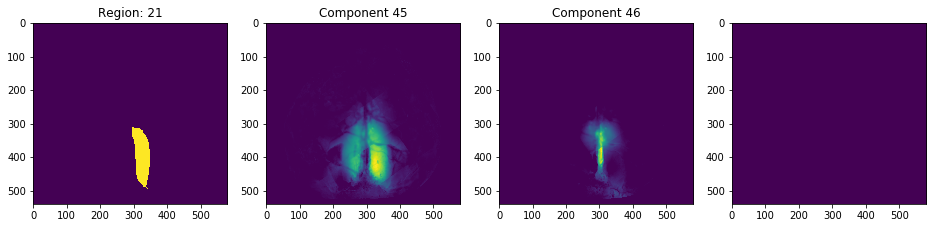

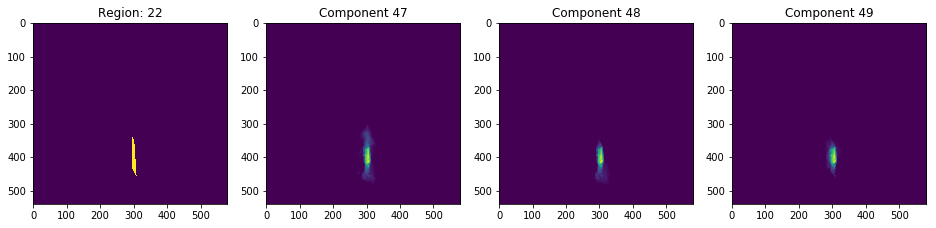

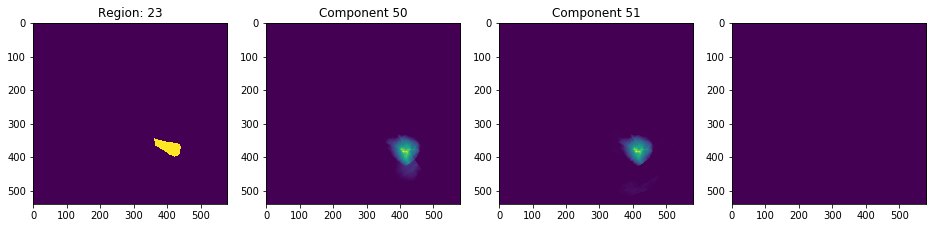

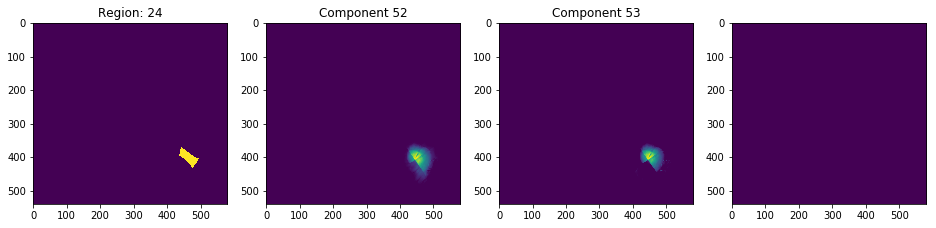

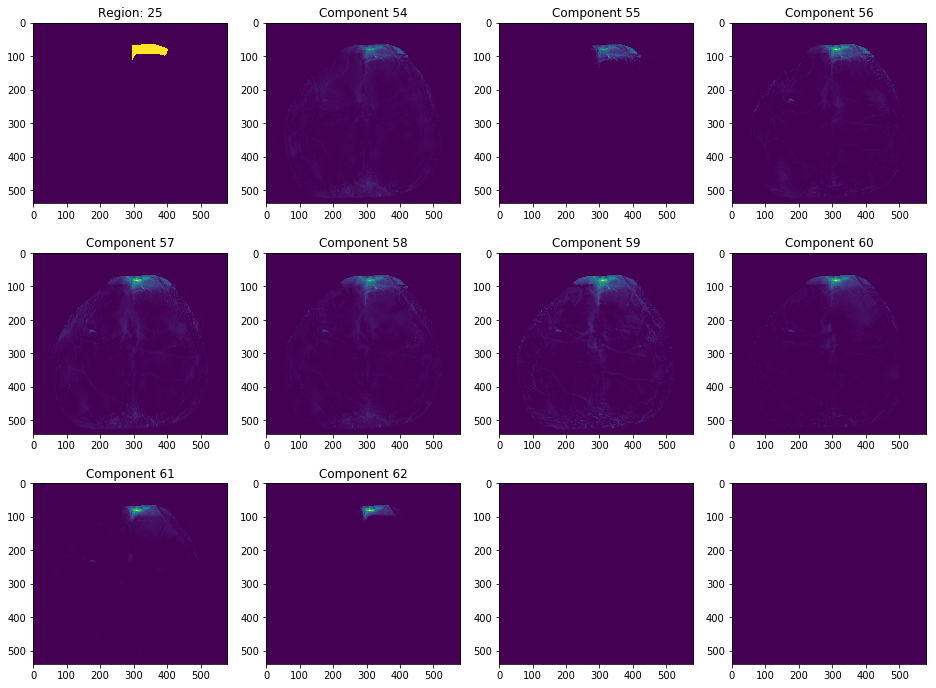

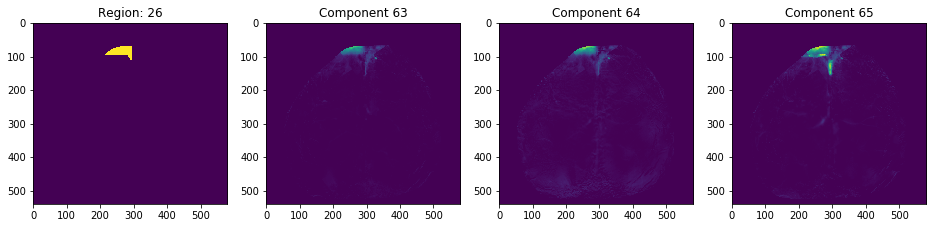

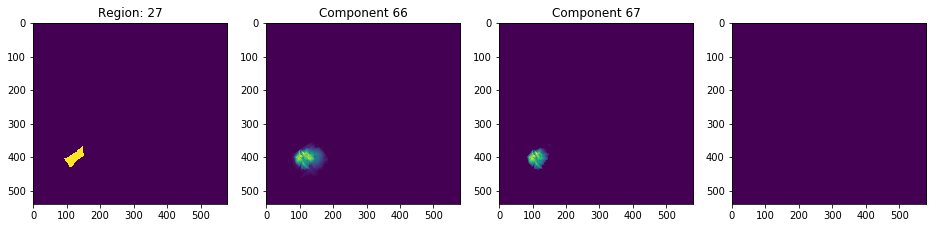

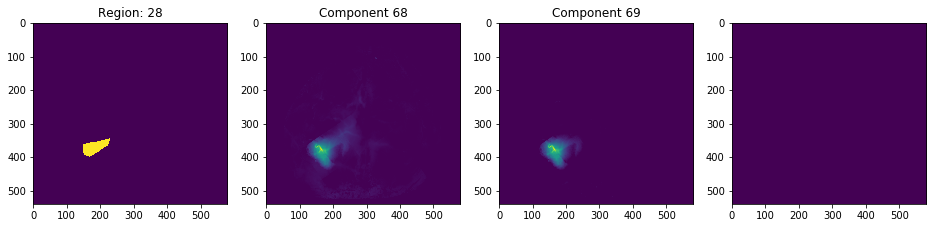

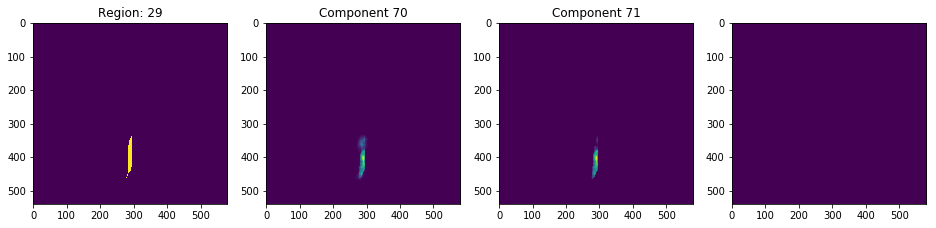

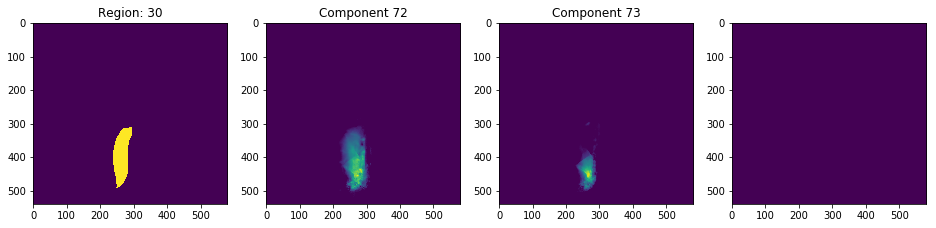

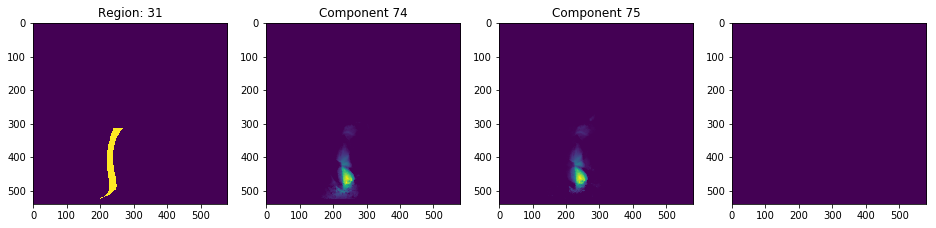

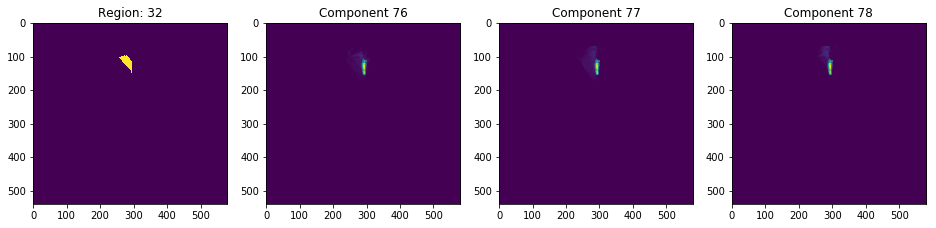

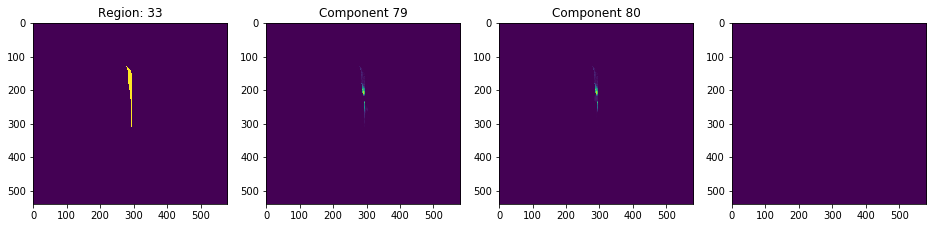

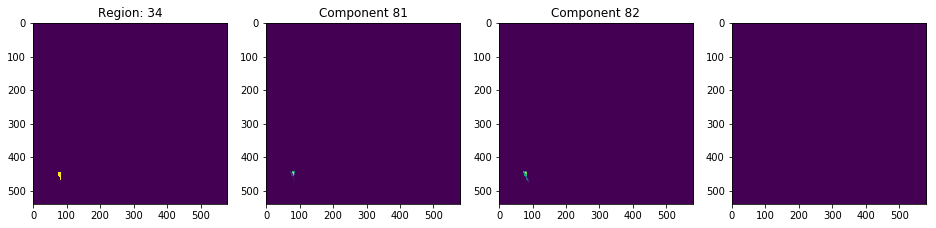

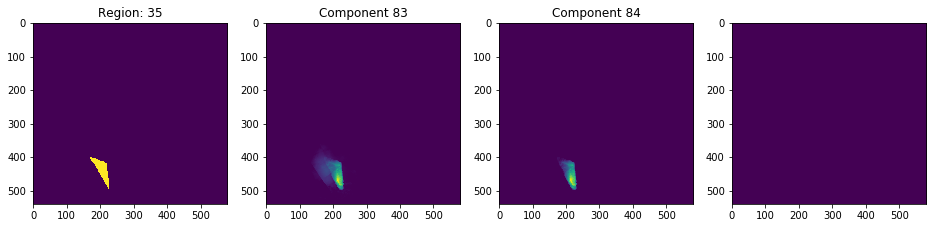

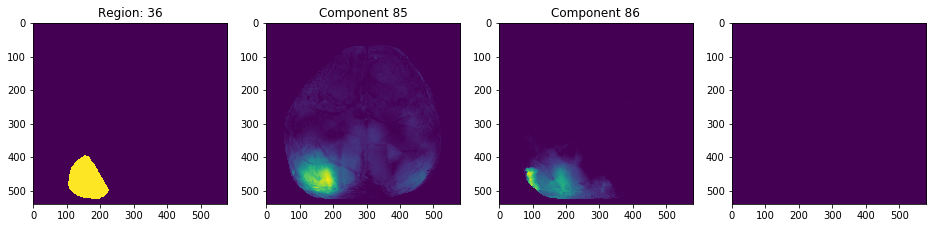

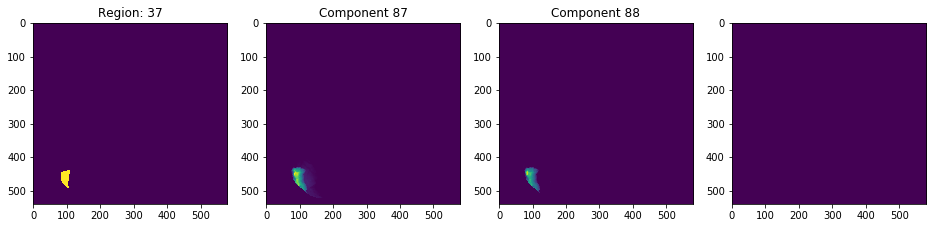

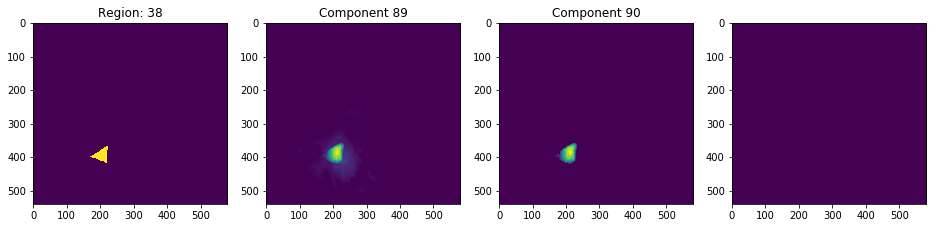

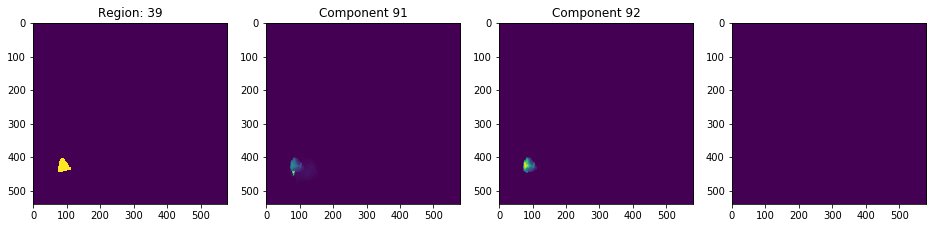

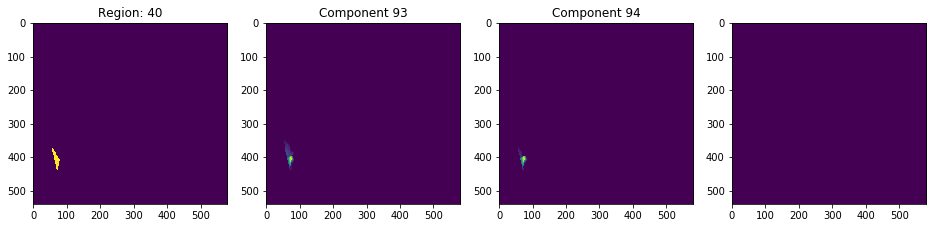

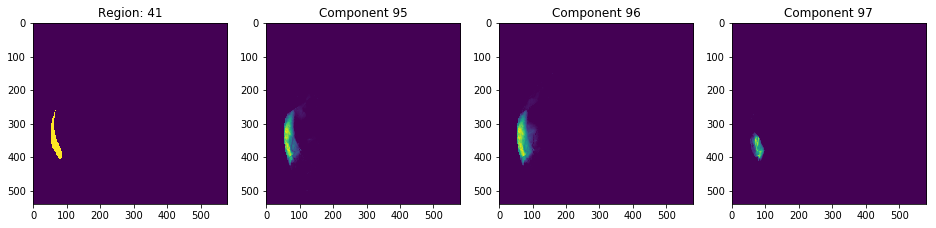

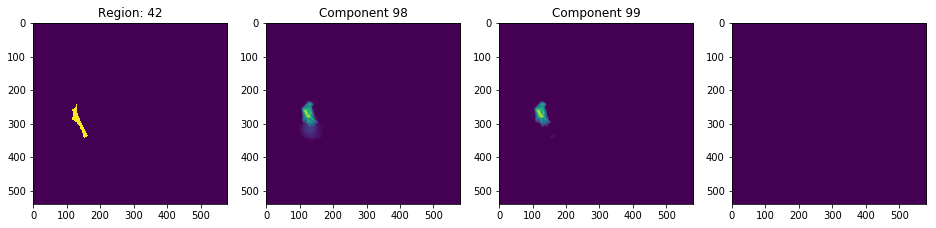

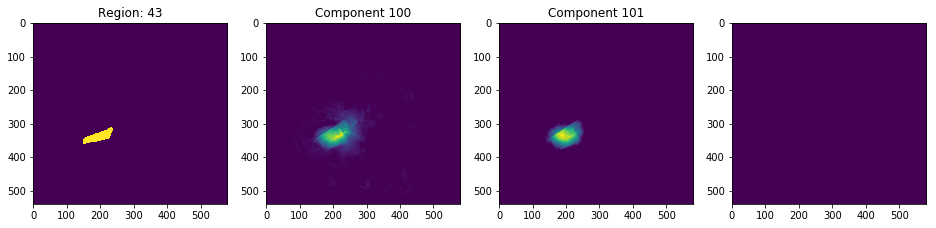

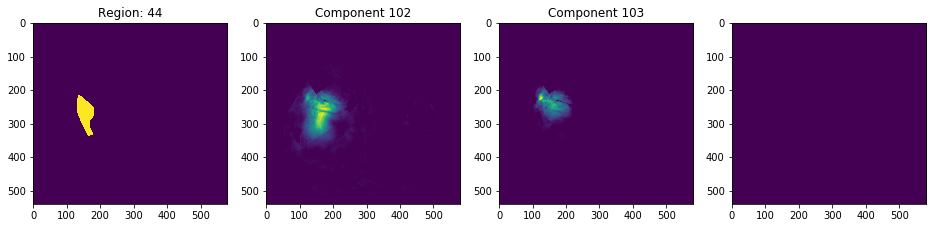

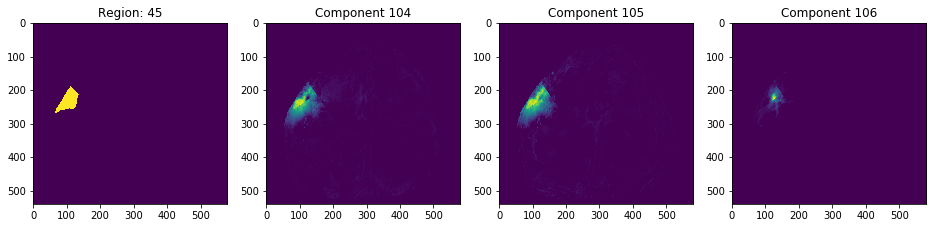

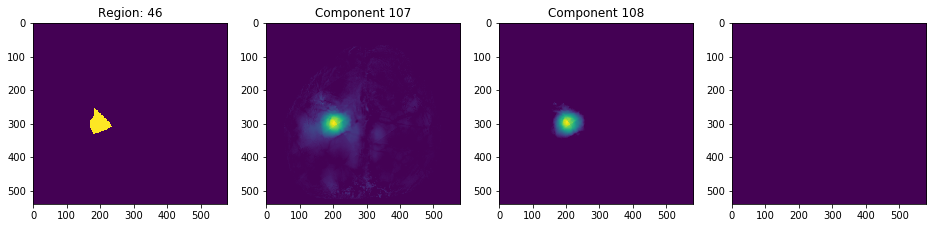

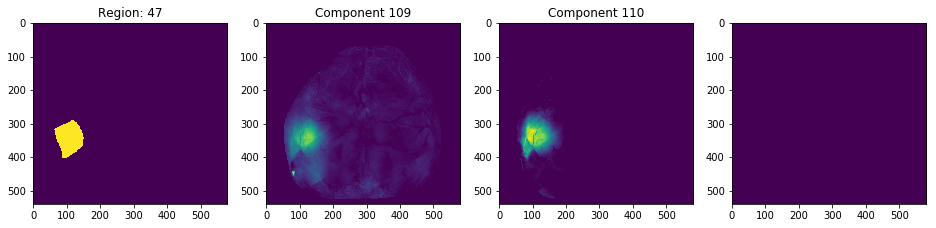

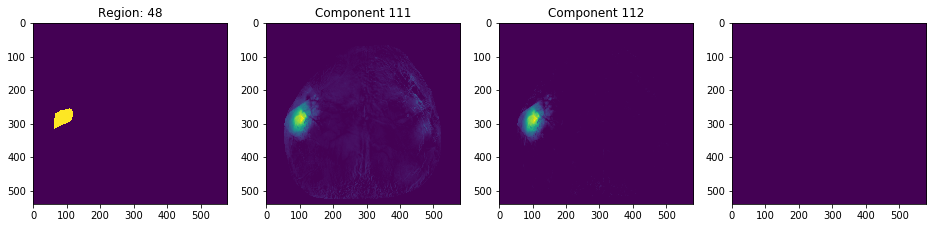

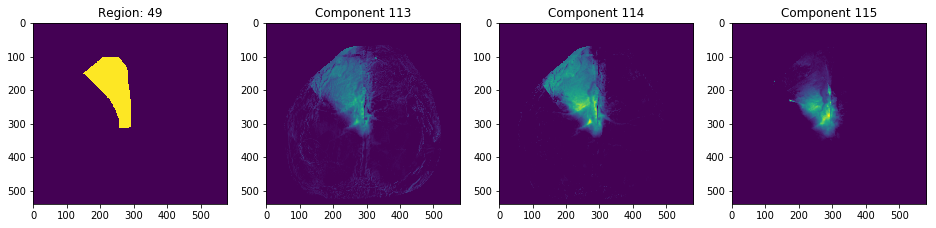

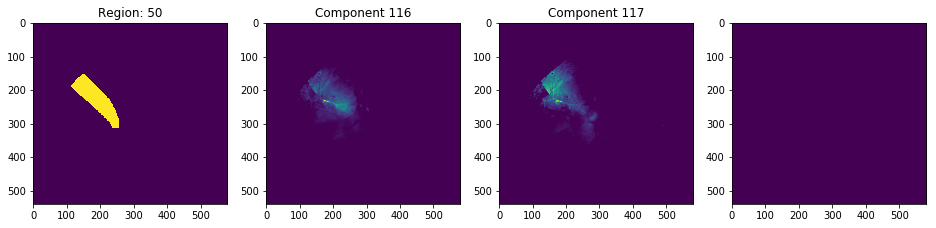

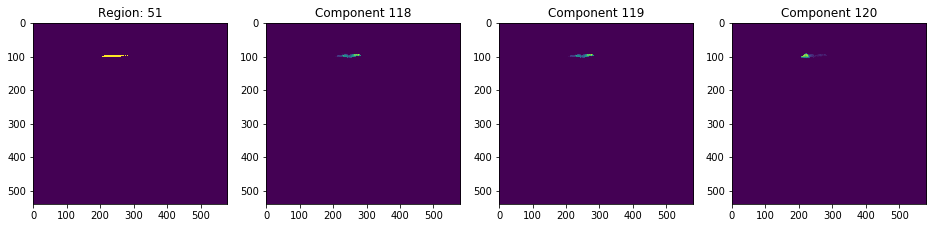

In [34]:
A = np.zeros(valid_mask.shape, dtype=np.float32)
for rdx, i in zip(region_idx, np.cumsum(region_ranks[:-1])):
    fig, axs = plt.subplots(1 + int(region_ranks[1+rdx] / 4), 4,
                            figsize=(16,(1 + int(region_ranks[1+rdx] / 4)) * 4))
    axs = axs.reshape((int(np.prod(axs.shape)),))
    A[valid_mask] = debug.distance.data[i].cpu()==0
    axs[0].imshow(A)
    axs[0].set_title("Region: {}".format(rdx+1))
    for j, ax in enumerate(axs[1:]):
        if i + j < len(debug) and debug.regions.data[i+j].item() == rdx:
            A[valid_mask] = debug.spatial.data[i+j].cpu()
            ax.set_title("Component {}".format(i+j))
        else:
            A[valid_mask] = 0
        ax.imshow(A)
        
    plt.show()

In [35]:
torch.min(debug.lambdas.data)

tensor(0.0010, device='cuda:0')

In [36]:
torch.max(debug.lambdas.data)

tensor(1803.1062, device='cuda:0')

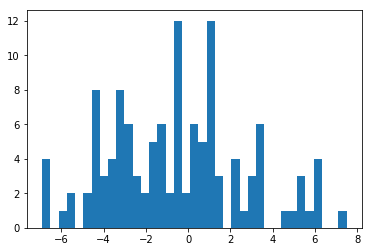

In [37]:
plt.hist(np.log(debug.lambdas.data.cpu()), bins=torch.unique(debug.lambdas.data).shape[0])
plt.show()